### ANN for regression, example 2, house market data (how to handle categorical variables)

##### Version 2: using some common optimization approaches (see also the first optimization examples, more explanations there)

#### Imports / modules

In [1]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

#### Loading the dataset

In [2]:
# load the data
df = pd.read_csv("Housing.csv")

In [3]:
# let's see the first 5 rows 
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df['furnishingstatus'].value_counts()

# usually we are only interested if the house
# is furnished AT ALL or completely unfurnished
# what if we combine semi-furnished with furnished?
# (there's no way knowing if this works, it's more about trying creative
# approaches in order to simplify/optimize the dataset)

furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64

### Handling the categorical variables

In [5]:
# WE HAVE SOME BOOLEAN CATEGORIES
# => change them to 0 and 1

# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder
variables = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [6]:
# let's see how our dataset now changed
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


### Convert text categories with multiple choices into multiple variables

In [7]:
# SINCE WE ARE GOING TO MODIFY THE furnishingstatus from three options
# to two options, we no longer need OneHotEncoder, since this is now 
# goint to be a boolean/binary variable

# # this makes multiple columns with the variable (Separate for yes/no)
# from sklearn.preprocessing import OneHotEncoder
# variables = ['furnishingstatus']

# # use encoder
# encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
# df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

#### This is an example where you can use your own ideas and creativity in order to optimize, modify or simplify the dataset

In [8]:
# create a helper function for pandas and replace
# the different furnishingstatus values into either 0 or 1
def modify_furnishing(row):
    if row['furnishingstatus'] == 'unfurnished':
        return 0
    else:
        return 1
    
# create a new boolean/binary furnished status 
# 0 => not furnished
# 1 => either fully or partially furnished
df['furnished'] = df.apply(modify_furnishing, axis=1)

# drop the original 3-option furnishing status
df = df.drop("furnishingstatus", axis=1)

In [9]:
# no longer needed, since we don't use OneHotEncoder anymore for this
# # we can alwasy remove EXACTLY ONE option per variable when we use OneHotEncoder
# df = df.drop("furnishingstatus_unfurnished", axis=1)

In [10]:
# let's see what happened to our dataset
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,1
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,1
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0


#### Removing outliers

In [11]:
# usually the most straight-forward / quick&dirty -solution is to use
# scipy and z-score

# version 1, SciPy, extreme outliers that go under -3 or over +3 in normal distribution
# from scipy import stats
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

# see also the quantile -based removal in Moodle, you have more control
# over what is removed

#### You can also get as fancy you wish with outlier detection and removal

In [12]:
# let's try a fancier example for outlier removal
# this code is originally from:
# https://stackoverflow.com/questions/69248118/detect-outliers-across-all-columns-of-pandas-dataframe

def find_outliers(col):
    q1 = col.quantile(.15)
    q3 = col.quantile(.85)
    IQR = q3 - q1
    ll = q1 - (1.5*IQR)
    ul = q3 + (1.5*IQR)
    upper_outliers = col[col > ul].index.tolist()
    lower_outliers = col[col < ll].index.tolist()
    bad_indices = list(set(upper_outliers + lower_outliers))
    return(bad_indices)

# get indexes of all outliers into a list
bad_indexes = []
for col in df.columns:
    if df[col].dtype in ["int64","float64"]:
        bad_indexes.append(find_outliers(df[col]))


# modify the list so that we can drop these rows from the DataFrame

bad_indexes = set(list(np.concatenate(bad_indexes).flat))

print(len(bad_indexes))

# drop the outliers
df = df.drop(bad_indexes)

145


<Axes: >

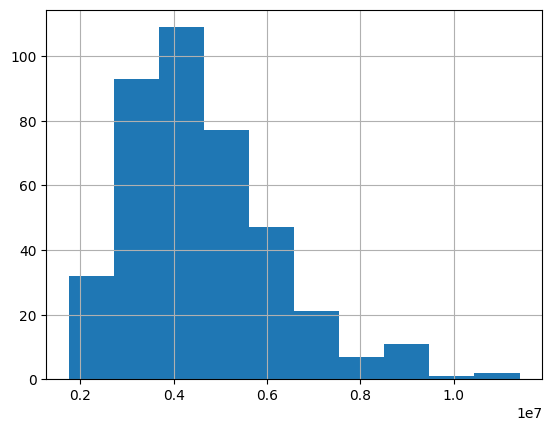

In [13]:
# it seems many of the more expensive houses were dropped off
# we still have slightly skewed distribution due to expensive houses

# unfortunately we don't have much data, so we can't really afford
# removing more outliers this time...

# remember, getting more and better data is always the best option to improve data!
df['price'].hist()

### X/y -split

In [14]:
# perform X/y -split
# if you  have more than one independent variable, list them all here
# leave out the target variable! (dependent variable)

# this is a nice and common trick => everything EXCEPT target variable => support variable
X = df.drop("price", axis=1)

# have only the target variable here (dependent variable)
y = df["price"]

#### Use the different tools to figure out which variables are important and which are not

In [15]:
# the most basic tool of them all => correlations
correlations = df.corr(numeric_only=True)
correlations

# based on this, pretty much everything correlates with price
# so we don't have unusable variables
# for some reason, mainroad and hotwaterheating show as NaN (not a number)
# probably not enough data or variance to show a correlation

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished
price,1.000000,0.473069,0.359088,0.448919,0.197588,NaN,0.328968,0.278424,NaN,0.454708,0.284935,0.351732,0.307927
area,0.473069,1.000000,0.111222,0.126659,-0.110831,NaN,0.168028,0.066453,NaN,0.182536,0.303068,0.221741,0.152440
bedrooms,0.359088,0.111222,1.000000,0.330146,0.436622,NaN,0.097721,0.131260,NaN,0.152619,0.107960,0.126326,0.145228
bathrooms,0.448919,0.126659,0.330146,1.000000,0.160032,NaN,0.113472,0.168793,NaN,0.145580,0.130359,0.074666,0.152133
stories,0.197588,-0.110831,0.436622,0.160032,1.000000,NaN,0.001267,-0.112666,NaN,0.135208,-0.122925,0.046513,0.057485
mainroad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guestroom,0.328968,0.168028,0.097721,0.113472,0.001267,NaN,1.000000,0.433041,NaN,0.135729,0.055286,0.191861,0.118929
basement,0.278424,0.066453,0.131260,0.168793,-0.112666,NaN,0.433041,1.000000,NaN,0.099762,0.067917,0.245653,0.108538
hotwaterheating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airconditioning,0.454708,0.182536,0.152619,0.145580,0.135208,NaN,0.135729,0.099762,NaN,1.000000,0.130278,0.101346,0.099891


#### Fisher score to important variables in the dataset

<Axes: >

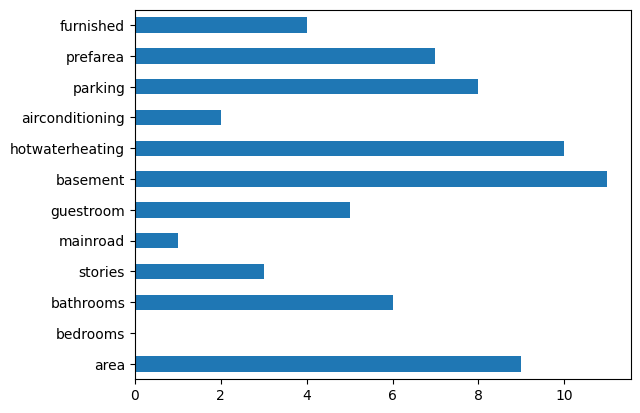

In [16]:
# pip install skfeature-chappers
from skfeature.function.similarity_based import fisher_score

# get the fisher's score rankings 
ranks = fisher_score.fisher_score(X.values, y.values)

# create a pandas DataFrame for easier interpretation
feat_importances = pd.Series(ranks, X.columns)
feat_importances.plot(kind='barh')

# how to interpret -> low score means the effect of this field is not large in the dataset
# => typically means other columns in the dataset have similar correlations, 
# therefore making this particular column not so useful since other columns 
# already fill this role for this correlation

# Fisher's score studies the variance of the data -> statistical significance'

# based on Fisher's score:
# num_rooms is not important at all, and num_people has minor importance in this data
# but ave_monthly_income is quite powerful based on Fisher's score

### SelectKBest to see important variables in the dataset

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on target variable
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
0,area,167273.94
9,parking,196.22
5,guestroom,184.47
10,prefarea,157.98
8,airconditioning,153.88
6,basement,127.87
11,furnished,72.54
3,stories,42.91
2,bathrooms,41.10
1,bedrooms,35.33


#### VIF-test -> detect variables that are too similar (redundancy/multicollinearity)

In [18]:
# pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
# VIF = Variance Inflation Factor
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  

# variables with high VIF-value 
# can mean multlicollinearity (variables providing same linear
# relationships in the data, potentially confusing the ML algorithm
# this might be good info when deciding if some variable needs to be removed
print(vif_data)

            feature   VIF
0              area  1.24
1          bedrooms  1.44
2         bathrooms  1.18
3           stories  1.39
4          mainroad 26.07
5         guestroom  1.28
6          basement  1.37
7   hotwaterheating   NaN
8   airconditioning  1.10
9           parking  1.16
10         prefarea  1.13
11        furnished  1.07


c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


### Train/test/validation -split

In [19]:
# in Classic ML, we only had train/test -split
# in deep learning, we usually use validation-data also, for better
# optimization possibilities and better metrics

# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.

# if you want to split the test set into two for a validation set too, try this trick:

# step 1, split the data into 70% (training data) and 30% (temporary data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# step 2, split the temporary data in HALF (0.5) => 15% test and 15% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

#### Create a neural network structure

Optimizations in place again, see the first optimization example for more explanations.

In [20]:
# create neural network

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# save the amount of support variables into a helper variable
# so we don't have to update the input_shape all the time
variable_amount = len(X.columns)

# create callbacks and place them into a parameter list
# NOTE! if you get PermissionError while training the model,
# just try training it again
mc = ModelCheckpoint('best_model_regression2_housing.keras', monitor='val_loss', mode='min', save_best_only=True)

# if you use multiple callbacks (EarlyStoppin, ReduceLROnPlateau etc.)
# add them to this same list
callback_list = [mc]

# Define Sequential neural network model
# input shape has to match the amount of SUPPORT VARIABLES
# in other words => amount of columns in X 

# Tip: have at least the same number of nodes as in the input shape

# since we have 13 support variables this time => 16 nodes in first layer

# different regularization in use this time!

# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.1)),
        layers.Dropout(0.2),
        layers.Dense(24, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
# model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer=keras.optimizers.RMSprop(0.00085), loss=keras.losses.Huber())
# model.compile(optimizer=keras.optimizers.SGD(0.001), loss="mse")
# an example where we alter the learning rate of Adam-optimizer

# we can adjust the hyperparameters for our optimizers and loss-functionts too, for example:
# see also commented code examples above ()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00125), loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,673 (6.54 KB)

 Trainable params: 1,649 (6.44 KB)

 Non-trainable params: 24 (96.00 B)

### Train the neural network, connect callbacks (ModelCheckpoint)

In [21]:
# train/fit neural network with validation data
# see the instructions on the train/test -split above on how to split the data correctly
model.fit(x=X_train, y=y_train, epochs=800, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 24742717292544.0000 - val_loss: 23262625005568.0000
Epoch 2/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24742711001088.0000 - val_loss: 23262616616960.0000
Epoch 3/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 24742706806784.0000 - val_loss: 23262612422656.0000
Epoch 4/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 24742700515328.0000 - val_loss: 23262608228352.0000
Epoch 5/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24742692126720.0000 - val_loss: 23262597742592.0000
Epoch 6/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 24742675349504.0000 - val_loss: 23262583062528.0000
Epoch 7/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 24742660669440.0000 - val_loss: 23262562091008.0000
Epoch 8/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 24742627115008.0000 - val_loss: 23262536925184.0000
Epoch 9/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 24742583074816.0000 - val_loss: 23262488690688.0000
Epoch 10/8

### Performance and error metrics

<Axes: >

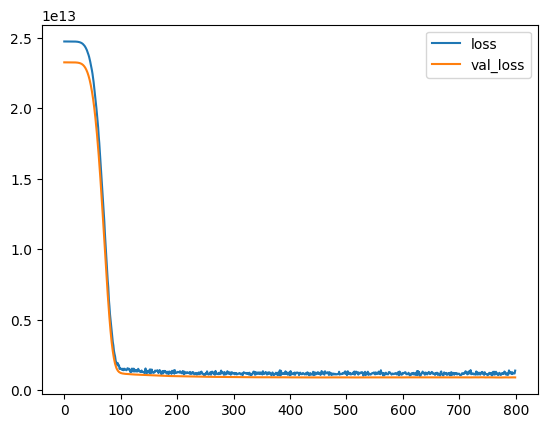

In [22]:
# let's use pandas for this (easy code)
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Reload the best version of the model from history

Basically replace the model version of LAST EPOCH with the best version from training history!

In [23]:
# reload model from best model checkpoint
from keras.models import load_model
model = load_model("best_model_regression2_housing.keras")

In [24]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
1195605622784.0

Train data evaluation:
960001998848.0


In [25]:
# get test predictions
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


,Test True Y,Model Predictions
0,4200000,4614287.50
1,7000000,6774323.50
2,3010000,4194349.50
3,3430000,3068602.25
4,2275000,3401636.75
5,5523000,5161378.50
6,3115000,3288312.25
7,4900000,4517897.50
8,4893000,6065172.50
9,2695000,2942574.75


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

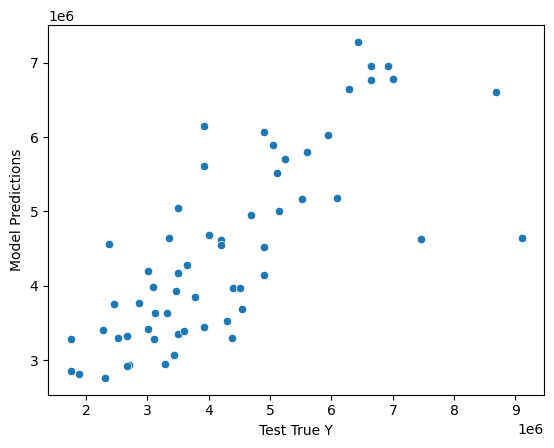

In [26]:
# these values follow a linear diagonal line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

### Much better metrics when compared to lecture 2, but still far from optimal! But it's a good start!

In [27]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
790285.12 $

MSE
1195605622784.0 $^2

RMSE:
1093437.53 $

R-squared:
0.56

Explained variance score:
0.57


C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_12364\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


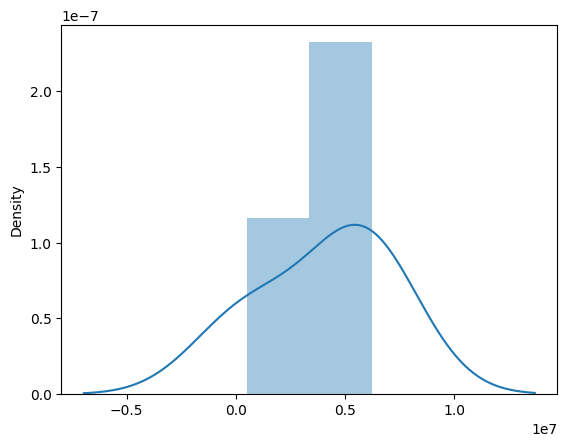

In [28]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

#### Trying the model in practice with new imaginary house

In [29]:
# just to see what kind of values are usually in the dataset
# so we can test with the tester_row
df.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,1
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1


### Since we change the furnished-variable, we have to modify the code below to match the new variables

In [33]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
    'area': 7420, 
    'bedrooms': 4, 
    'bathrooms': 2, 
    'stories': 3, 
    'mainroad': 1,
    'guestroom': 0, 
    'basement': 0, 
    'hotwaterheating': 0, 
    'airconditioning': 1,
    'parking': 2,
    'prefarea': 1,
    'furnished': 1
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [35]:
# get the prediction from the model and print out the result
result = model.predict(tester_row)[0]

print()
print(f"Estimated house price with this example:")
print(f"$ {round(float(result[0]), 2)}")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Estimated house price with this example:
$ 7629409.0
----------------


In [ ]:
# the model above undershoots the estimation
# should be 13.3 million => prediction is 6.45 million